In [2]:
import sys
import os 

sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

In [3]:
import numpy as np
import pandas as pd

import torch
from datasets import load_dataset
from torch import nn
from tqdm import tqdm, trange
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from torch.utils.data import DataLoader
import pickle
from src import AI_IRW, OODDetector

from scipy.spatial.distance import mahalanobis, cdist

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("fabriceyhc/bert-base-uncased-imdb")

model = AutoModelForSequenceClassification.from_pretrained("fabriceyhc/bert-base-uncased-imdb")


In [5]:
dataset = load_dataset("imdb")



Found cached dataset imdb (/home/onyxia/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
class LatentBert(nn.Module):

    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.N = len(self.base_model.bert.encoder.layer)

    def to(self, device):
        self.base_model.to(device)
        return self

    def forward(self, x, aggregated=True):
        
        x = self.base_model.bert.embeddings(x)
        latent_reps = torch.zeros((x.shape[0], x.shape[2],self.N)
        )
        for i, layer in enumerate(self.base_model.bert.encoder.layer) :
            x = layer(x)[0]
            latent_reps[:,:,i] = x[:,0,:] #Pooling is done by taking the hidden state of first token (cf Bert implementation)
        
        x_ = self.base_model.bert.pooler(x)
        x = self.base_model.classifier(x_)
                
        return {"embeddings" : torch.mean(latent_reps, axis=-1) if aggregated else latent_reps, "logits": x, "attention": x_}
        

In [7]:
lb = LatentBert(base_model=model).to('cuda')

In [7]:
train_in_dl = DataLoader(dataset['train'], batch_size=8)

environ 14min

In [8]:
embds = []
logits = []
attns = []
for i,batch in enumerate(tqdm(train_in_dl)):
    data = batch['text']
    tk_batch = tokenizer(data,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
    outputs = lb.forward(tk_batch, aggregated=False)
    embds.append(outputs['embeddings'].cpu().detach())
    logits.append(outputs['logits'].cpu().detach())
    attns.append(outputs['attention'].cpu().detach())


100%|██████████| 3125/3125 [12:14<00:00,  4.25it/s]


In [9]:
with open('../nlp_data/embeddings_imbd_train.pkl', 'wb') as f:
    pickle.dump(embds, f)

with open('../nlp_data/logits_imdb_train.pkl', 'wb') as f:
    pickle.dump(logits, f)
    
with open('../nlp_data/attns_imdb_train.pkl', 'wb') as f:
    pickle.dump(attns, f)

In [10]:
oods = dict(multi30k = ["nlphuji/flickr30k"],
sst2 = ["sst2"],
wmt16 = ['wmt16', 'de-en'],
newsgroup = ["SetFit/20_newsgroups"])

collate_fns = dict(
    multi30k= lambda x : x[1]['caption'][0], 
    sst2= lambda x: [el['sentence'] for el in x], 
    wmt16 = lambda x : [el['translation']['en'] for el in x], 
    newsgroup=lambda x : [el['text'].replace('\n', ' ').replace("\\", '') for el in x ]
)

batch_sizes = dict(
    multi30k= 16, 
    sst2= 16, 
    wmt16 = 16, 
    newsgroup=4
)

In [11]:
for ds_n, ds in oods.items():
    out_dataset  =  load_dataset(*ds)
    ood_dl = DataLoader(dataset=out_dataset['test'],
                        batch_size=batch_sizes[ds_n], 
                        collate_fn= collate_fns[ds_n], #for flickr
                        )
    embds = []
    logits = []
    attns = []
    for batch in tqdm(ood_dl):
        tk_batch = tokenizer(batch,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
        outputs = lb.forward(tk_batch, aggregated=False)
        embds.append(outputs['embeddings'].cpu().detach())
        logits.append(outputs['logits'].cpu().detach())
        attns.append(outputs['attention'].cpu().detach())

    with open(f'../nlp_data/embeddings_ood_test_{ds_n}.pkl', 'wb') as f:
        pickle.dump(embds, f)

    with open(f'../nlp_data/logits_ood_test_{ds_n}.pkl', 'wb') as f:
        pickle.dump(logits, f)

    with open(f'../nlp_data/attns_ood_test_{ds_n}.pkl', 'wb') as f:
        pickle.dump(attns, f)

Found cached dataset flickr30k (/home/onyxia/.cache/huggingface/datasets/nlphuji___flickr30k/TEST/1.1.0/6adb9ab2367c57c3e81e76ecaecb8047ea00c33dccf9da10455037f32ec43382)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1939/1939 [07:08<00:00,  4.52it/s]
Found cached dataset sst2 (/home/onyxia/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 114/114 [00:05<00:00, 22.60it/s]
Found cached dataset wmt16 (/home/onyxia/.cache/huggingface/datasets/wmt16/de-en/1.0.0/746749a11d25c02058042da7502d973ff410e73457f3d305fc1177dc0e8c4227)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 188/188 [00:08<00:00, 20.92it/s]
Found cached dataset json (/home/onyxia/.cache/huggingface/datasets/SetFit___json/SetFit--20_newsgroups-f9362e018b6adf67/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 1883/1883 [02:46<00:00, 11.34it/s]


In [8]:
test_in_dl = DataLoader(dataset['test'], batch_size=8)

environ 14 min

In [9]:
embds = []
logits = []
attns = []
for i, batch in enumerate(tqdm(test_in_dl)):
    data = batch['text']
    tk_batch = tokenizer(data,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
    outputs = lb.forward(tk_batch, aggregated=False)
    embds.append(outputs['embeddings'].cpu().detach())
    logits.append(outputs['logits'].cpu().detach())
    attns.append(outputs['attention'].cpu().detach())

100%|██████████| 3125/3125 [12:07<00:00,  4.29it/s]


In [10]:
with open('../nlp_data/embeddings_raw_test.pkl', 'wb') as f:
    pickle.dump(embds, f)

with open('../nlp_data/logits_test.pkl', 'wb') as f:
    pickle.dump(logits, f)

with open('../nlp_data/attns_test.pkl', 'wb') as f:
    pickle.dump(attns, f)

In [11]:
with open('../nlp_data/embeddings_raw_imbd_train.pkl', 'rb') as f:
    embd_train = pickle.load(f)

with open('../nlp_data/embeddings_raw_ood_test_sst2.pkl', 'rb') as f:
    embd_ood = pickle.load(f)

with open('../nlp_data/embeddings_raw_ood_test_wmt16.pkl', 'rb') as f:
    embd_ood_test = pickle.load(f)

with open('../nlp_data/embeddings_raw_imdb_test.pkl', 'rb') as f:
    embd_test = pickle.load(f)

In [12]:
embd_train = torch.cat(embd_train).numpy()
embd_ood = torch.cat(embd_ood).numpy()
embd_ood_test = torch.cat(embd_ood_test).numpy()
embd_test = torch.cat(embd_test).numpy()

In [13]:
embd_train.shape

(25000, 768, 12)

In [14]:
embd_ood_mean = np.mean(embd_ood, axis=0)
embd_train_mean = np.mean(embd_train, axis=0)
embd_test_mean = np.mean(embd_test, axis=0)
embd_ood_test_mean = np.mean(embd_ood_test, axis=0)


OOD_cov = np.mean([embd_ood[i].T@embd_ood[i] for i in range(embd_ood.shape[0])], axis=0)
train_cov = np.mean([embd_train[i].T@embd_train[i] for i in range(embd_train.shape[0])], axis=0)

In [15]:
G = OOD_cov + train_cov - (embd_train_mean-embd_ood_mean).T@(embd_train_mean-embd_ood_mean)

In [16]:
eig_val, eig_vec = np.linalg.eig(G)

In [17]:
eig_vec = eig_vec[np.argsort(eig_val)]
eig_val = np.sort(eig_val)

In [18]:
eig_val

array([  13.851282,   19.668097,   27.753986,   30.472715,   56.42598 ,
         68.87759 ,  140.54445 ,  182.08559 ,  278.2384  ,  465.95258 ,
       1137.804   , 4231.73    ], dtype=float32)

In [199]:
embd_ood_eig = embd_ood@eig_vec[0]
embd_ood_test_eig = embd_ood_test@eig_vec[0]
embd_train_eig = embd_train@eig_vec[0]
embd_test_eig = embd_test@eig_vec[0]

In [198]:
from scipy.spatial.distance import cdist

In [206]:
scores_in = np.sum(cdist(embd_train_eig, embd_test_eig), axis=0)
scores_out = np.sum(cdist(embd_train_eig, embd_ood_test_eig), axis=0)


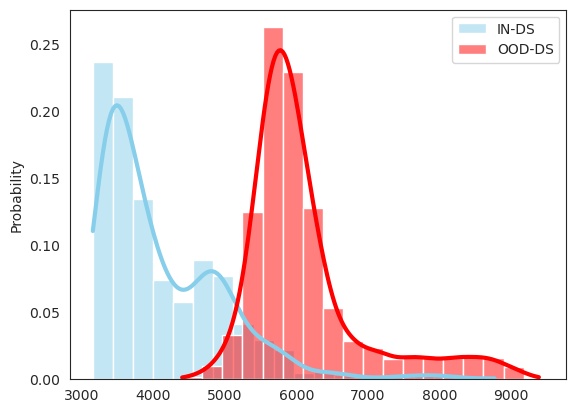

In [208]:
bins_width = (np.histogram(scores_in)[1][3]-np.histogram(scores_in)[1][2])/2
sns.histplot(scores_in, label='IN-DS', kde=True, stat='probability', color='skyblue', binwidth=bins_width, line_kws={"lw":3})
sns.histplot(scores_out, label='OOD-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3})
plt.legend()
plt.savefig('../figures/l2_opt.png')
plt.show()

In [209]:
scores_in = np.sum(cdist(embd_train_mean, embd_test_mean), axis=0)
scores_out = np.sum(cdist(embd_train_mean, embd_ood_mean), axis=0)


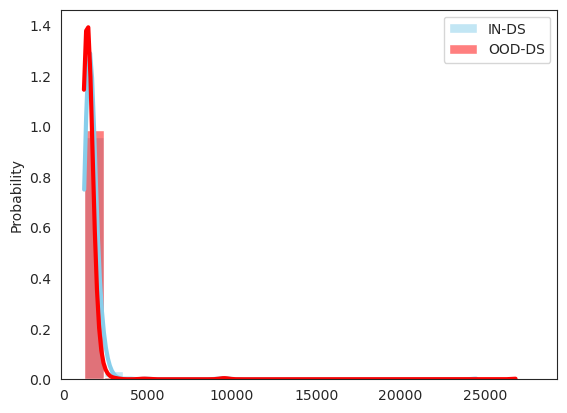

In [210]:
bins_width = (np.histogram(scores_in)[1][3]-np.histogram(scores_in)[1][2])/2
sns.histplot(scores_in, label='IN-DS', kde=True, stat='probability', color='skyblue', binwidth=bins_width, line_kws={"lw":3})
sns.histplot(scores_out, label='OOD-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3})
plt.legend()
plt.savefig('../figures/l2_mean.png')
plt.show()


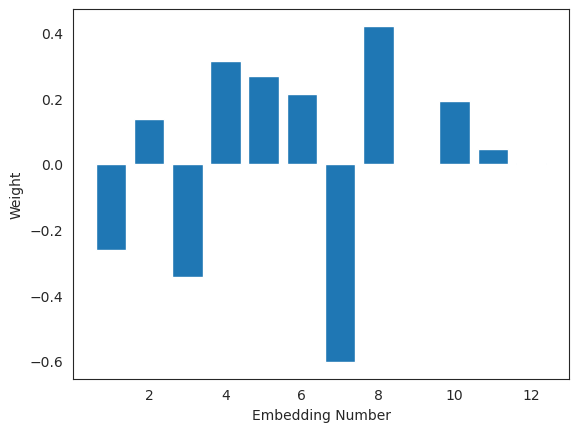

In [235]:
plt.bar(x = np.arange(1, len(eig_vec[0])+1), height=eig_vec[0])
plt.xlabel("Embedding Number")
plt.ylabel("Weight")
plt.show()

In [232]:
np.arange(1, len(eig_vec[0])+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])